CODE TO IMPLEMENT A RANDOM WALK <br>
This code implements a random walk in the search space (with 6 target states).
It simulates variours instaces of valid TSP solutions where agent starts from a state and returns to that state after visiting every target state.

The total reward is also calculated for each epoch, the plot in the end shows the path followed by the agent for the last episode.



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 30.8 MB/s eta 0:00:00
Episode 0, Step 1: Action = 2, Reward = -29.794499754755225
Episode 0, Step 2: Action = 1, Reward = -26.004686682753928
Episode 0, Step 3: Action = 5, Reward = -6.00626473768582
Episode 0, Step 4: Action = 3, Reward = -26.849795908489238
Episode 0, Step 5: Action = 4, Reward = -5.309946046379934
Episode 0, Step 6: Action = 0, Reward = -24.0274699794449
Episode 0 : Total Reward = -117.99266310950904
Episode 1, Step 1: Action = 1, Reward = -4.7233470655766805
Episode 1, Step 2: Action = 3, Reward = -24.86398296170198
Episode 1, Step 3: Action = 5, Reward = -26.849795908489238
Episode 1, Step 4: Action = 4, Reward = -23.95295962793962
Episode 1, Step 5: Action = 2, Reward = -8.151058686632325
Episode 1, Step 6: Action = 0, Reward = -29.794499754755225
Episode 1 : Total Reward = -118.33564400509506
Episode 2, Step 1: Action = 2, Reward = -29.794499754755225
Episode 2, Step 2: Action = 3, Reward = -3.1626158445

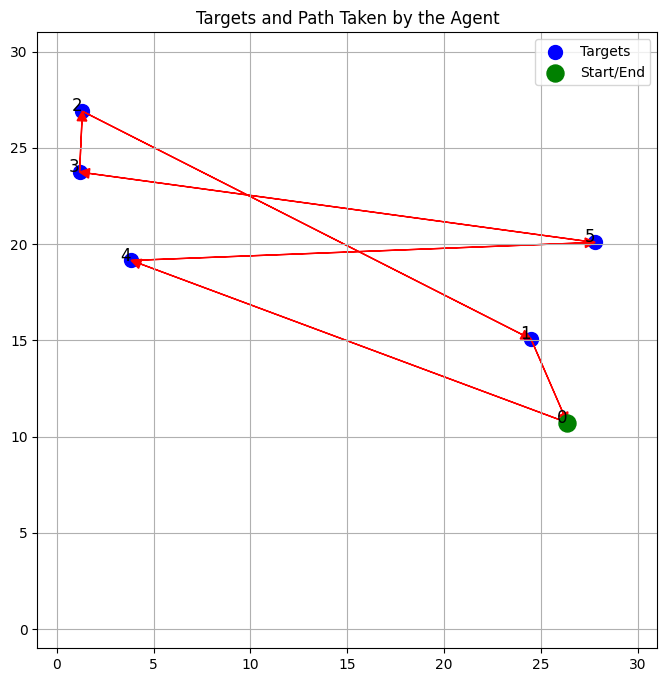

In [1]:
!pip install gymnasium
"""Environment for Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np


class TSP(gym.Env):
    """Traveling Salesman Problem (TSP) RL environment for persistent monitoring.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets in the least number of steps, with rewards determined by the distance traveled.
    """

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Max Square area where the targets are defined. Defaults to 30
            seed (int, optional): Random seed for reproducibility. Defaults to None.
        """
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)
        self.visited_targets = []

        # Observation Space : {current loc (loc), dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0

        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(
        self, action: int
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        points = []
        # Generate n random 2D points within the 10x10 grid
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        """Calculate the distance matrix between all target locations.

        Args:
            locations (List): List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            past_loc (int): Previous location of the agent.
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -10000
        return reward


import matplotlib.pyplot as plt

if __name__ == "__main__":
    num_targets = 6

    env = TSP(num_targets)
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs, _ = env.reset()
        visited = [False] * num_targets
        visited[0] = True  # Node 0 is the start node and is already visited
        steps = 0
        env.loc = 0  # Set the initial location to the start node (node 0)
        first_action = None  # Track the first action

        while steps < num_targets:
            available_actions = [
                i for i in range(num_targets) if not visited[i]
            ]

            if available_actions:
                # Select a node that hasn't been visited
                action = np.random.choice(available_actions)
                if first_action is None:  # Record the first action
                    first_action = action
            else:
                # If all nodes have been visited, return to the start node (node 0)
                action = 0

            obs_, reward, terminated, truncated, info = env.step(action)
            visited[action] = True
            ret += reward
            steps += 1

            # Print action and reward
            print(f"Episode {ep}, Step {steps}: Action = {action}, Reward = {reward}")

            if terminated or truncated:
                break

        ep_rets.append(ret)
        print(f"Episode {ep} : Total Reward = {ret}")

    print("Average Reward over 100 episodes:", np.mean(ep_rets))

    # Plot targets and path taken by the agent after the last episode
    visited_targets = env.visited_targets
    locations = env.locations

    plt.figure(figsize=(8, 8))
    plt.scatter(locations[:, 0], locations[:, 1], c='blue', label='Targets', s=100)

    # Label target nodes
    for i in range(num_targets):
        plt.text(locations[i][0], locations[i][1], str(i), fontsize=12, ha='right')

    # Plot the path taken by the agent with arrows connecting states
    if first_action is not None:
        # Draw arrow from node 0 to the first action
        plt.arrow(
            locations[0][0], locations[0][1],
            locations[first_action][0] - locations[0][0],
            locations[first_action][1] - locations[0][1],
            head_width=0.5, head_length=0.5, fc='red', ec='red',
            length_includes_head=True
        )

    for i in range(len(visited_targets) - 1):
        start_idx = visited_targets[i]
        end_idx = visited_targets[i + 1]
        plt.arrow(
            locations[start_idx][0], locations[start_idx][1],
            locations[end_idx][0] - locations[start_idx][0],
            locations[end_idx][1] - locations[start_idx][1],
            head_width=0.5, head_length=0.5, fc='red', ec='red',
            length_includes_head=True
        )

    # Highlight the start and end locations (node 0)
    plt.scatter(locations[0][0], locations[0][1], c='green', label='Start/End', s=150)

    plt.title("Targets and Path Taken by the Agent")
    plt.legend()
    plt.grid(True)
    plt.xlim(-1, env.max_area + 1)
    plt.ylim(-1, env.max_area + 1)
    plt.show()

CODE TO IMPLEMENT DYNAMIC PROGRAMMING SOLUTION - USING POLICY ITERATION <br>
The MDP has been formulated as follows :-
1. The states consist of a 2 tuple, one is the current node and other is a list containing all visited nodes.
2. Actions are all possible targets i.e. (0,1,2,3,4,5) for the case where we have 6 targets.
3. 0 is the start node i.e. (0, ()) is the start state. 
4. The transition probabilty is always 1 for a given state and action as the environment dynamics are deterministic- the agent always goes to a fixed state given any state (current and visited states pair) and action.
5. If the agent goes from state i to state j it gets a reward equal to negative of the distance between them, and it gets a large negative reward to return to already visited node.

In [2]:
import gymnasium as gym
import numpy as np
from itertools import permutations


class TSP(gym.Env):
    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Observation Space: {current loc (loc), dist_array (distances), coordinates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        self.steps: int = 0
        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -1000000000
        return reward


def policy_iteration(env: TSP, gamma=1, theta=1e-6, max_iterations=1000):
    num_targets = env.num_targets

    def state_to_index(state):
        """Helper function to convert state (location, visited targets) into a unique index"""
        loc, visited = state
        return loc, tuple(sorted(visited))  # Convert visited to a tuple for immutability

    def get_all_states():
        """Generates all possible states (combinations of visited targets)"""
        states = []
        for visited in range(1 << num_targets):
            visited_list = [i for i in range(num_targets) if visited & (1 << i)]
            for loc in range(num_targets):
                states.append((loc, tuple(visited_list)))  # Convert visited_list to tuple
        return states

    # Initialize arbitrary policy and value function
    policy = {}
    V = {}

    # Initialize value function and policy
    all_states = get_all_states()
    for state in all_states:
        loc, visited = state
        V[state] = 0

        # If all targets are visited, the next action should be to return to the start node (0)
        if len(visited) == num_targets:
            policy[state] = 0  # Go back to start
        else:
            # Select a random unvisited target
            available_actions = [i for i in range(num_targets) if i not in visited]
            if available_actions:
                policy[state] = np.random.choice(available_actions)
            else:
                policy[state] = 0  # Fall back to starting node if something goes wrong

    # Policy Iteration Loop
    for i in range(max_iterations):
        # Policy Evaluation
        while True:
            delta = 0
            for state in all_states:
                old_value = V[state]
                loc, visited = state

                if len(visited) == num_targets:  # All cities visited, return to start
                    V[state] = -env.distances[loc][0]
                else:
                    action = policy[state]
                    reward = -env.distances[loc][action]

                    # Ensure the action hasn't already been visited
                    if action in visited:
                        continue

                    next_visited = list(visited) + [action]
                    next_state = (action, tuple(sorted(next_visited)))  # Create next state

                    # Check if next_state is valid in V
                    if next_state not in V:
                        V[next_state] = 0  # Initialize if not already present

                    V[state] = reward + gamma * V[next_state]

                delta = max(delta, abs(old_value - V[state]))
            if delta < theta:
                break

        # Policy Improvement
        policy_stable = True
        for state in all_states:
            loc, visited = state
            if len(visited) == num_targets:
                continue  # No need to improve policy for terminal state

            old_action = policy[state]
            action_values = []
            for action in range(num_targets):
                if action not in visited:
                    reward = -env.distances[loc][action]
                    next_visited = list(visited) + [action]
                    next_state = (action, tuple(sorted(next_visited)))  # Create next state

                    # Ensure next_state is valid in V
                    if next_state not in V:
                        V[next_state] = 0  # Initialize if not already present

                    action_values.append(reward + gamma * V[next_state])

            if action_values:  # Avoid empty list errors
                best_action = np.argmax(action_values)
                policy[state] = best_action

            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            break

    return policy, V


if __name__ == "__main__":
    num_targets = 6
    env = TSP(num_targets)

    # Perform policy iteration
    optimal_policy, optimal_values = policy_iteration(env)

    print("Optimal Policy:", optimal_policy)
    print("Optimal Values:", optimal_values)




Optimal Policy: {(0, ()): 5, (1, ()): 5, (2, ()): 5, (3, ()): 3, (4, ()): 4, (5, ()): 5, (0, (0,)): 2, (1, (0,)): 0, (2, (0,)): 1, (3, (0,)): 2, (4, (0,)): 0, (5, (0,)): 4, (0, (1,)): 0, (1, (1,)): 3, (2, (1,)): 0, (3, (1,)): 0, (4, (1,)): 3, (5, (1,)): 4, (0, (0, 1)): 1, (1, (0, 1)): 2, (2, (0, 1)): 0, (3, (0, 1)): 1, (4, (0, 1)): 2, (5, (0, 1)): 2, (0, (2,)): 2, (1, (2,)): 1, (2, (2,)): 2, (3, (2,)): 2, (4, (2,)): 3, (5, (2,)): 4, (0, (0, 2)): 1, (1, (0, 2)): 2, (2, (0, 2)): 1, (3, (0, 2)): 1, (4, (0, 2)): 2, (5, (0, 2)): 2, (0, (1, 2)): 0, (1, (1, 2)): 2, (2, (1, 2)): 1, (3, (1, 2)): 1, (4, (1, 2)): 2, (5, (1, 2)): 3, (0, (0, 1, 2)): 0, (1, (0, 1, 2)): 1, (2, (0, 1, 2)): 0, (3, (0, 1, 2)): 0, (4, (0, 1, 2)): 1, (5, (0, 1, 2)): 2, (0, (3,)): 2, (1, (3,)): 1, (2, (3,)): 2, (3, (3,)): 2, (4, (3,)): 3, (5, (3,)): 4, (0, (0, 3)): 1, (1, (0, 3)): 0, (2, (0, 3)): 1, (3, (0, 3)): 1, (4, (0, 3)): 3, (5, (0, 3)): 3, (0, (1, 3)): 1, (1, (1, 3)): 2, (2, (1, 3)): 1, (3, (1, 3)): 1, (4, (1, 3)): 

This code traces the path the agent travels when it starts from the node 0. <br>
The optimal path for this TSP instance is 0 -> 5 -> 4 -> 3 -> 2 -> 1 -> 0

In [3]:
# Function to trace the path
def trace_optimal_path(start_state, optimal_policy):
    current_state = start_state
    visited_nodes = []
    path = []

    while True:
        visited_nodes.append(current_state[0])
        next_node = optimal_policy[current_state]
        path.append((current_state[0], next_node))
        current_state = (next_node, tuple(sorted(visited_nodes)))
        if next_node == 0:
            break

    return path

start_state = (0, ())
path = trace_optimal_path(start_state, optimal_policy)
print(path)


[(0, 5), (5, 4), (4, 3), (3, 2), (2, 1), (1, 0)]


IMPLEMENTATION OF MONTE CARLO (MC) METHOD - USING EVERY VISIT FOR POLICY EVALUATION <br>
Every-visit Monte Carlo updates the value function for each state-action pair whenever it is encountered in an episode, regardless of whether it has been encountered before in that same episode. <br>
In the code, we maintain a list of rewards for each state-action pair in the returns dictionary, and after each episode, we append the return for every visit of a state-action pair. This means that if a state-action pair is visited multiple times within the same episode, each occurrence will contribute to the update of the value estimate for that state-action pair.

In [5]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

class TSP(gym.Env):
    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Observation Space: {current loc (loc), dist_array (distances), coordinates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        self.steps: int = 0
        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -1000000000
        return reward


def monte_carlo_tsp(env: TSP, episodes: int = 10000, gamma: float = 1.0, epsilon: float = 0.1):
    num_targets = env.num_targets

    # Initialize value function and returns
    V = defaultdict(float)
    returns = defaultdict(list)
    policy = {}

    def get_action(state, epsilon):
        """Epsilon-greedy action selection"""
        if np.random.random() < epsilon:
            available_actions = [i for i in range(num_targets) if i not in state[1]]
            return np.random.choice(available_actions)
        else:
            return policy.get(state, np.random.choice([i for i in range(num_targets) if i not in state[1]]))

    for episode in range(episodes):
        state, _ = env.reset()
        state = (int(state[0]), tuple())

        # Generate an episode
        episode_data = []
        for t in range(num_targets):
            action = get_action(state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = (int(next_state[0]), tuple(env.visited_targets))

            episode_data.append((state, action, reward))
            state = next_state

            if done or truncated:
                break

        # Calculate returns and update value function
        G = 0
        for step in reversed(episode_data):
            state, action, reward = step
            G = reward + gamma * G
            returns[(state, action)].append(G)
            V[(state, action)] = np.mean(returns[(state, action)])

        # Update policy greedily
        for step in episode_data:
            state, action, _ = step
            best_action = max(range(num_targets), key=lambda a: V[(state, a)] if a not in state[1] else -float('inf'))
            policy[state] = best_action

    return policy, V


if __name__ == "__main__":
    num_targets = 10
    env = TSP(num_targets)

    # Perform Monte Carlo simulation
    optimal_policy, optimal_values = monte_carlo_tsp(env)

    print("Optimal Policy:", optimal_policy)
    print("Optimal Values:", optimal_values)


Optimal Policy: {(0, ()): 3, (0, (0,)): 4, (5, (0, 5)): 1, (7, (0, 5, 7)): 1, (4, (0, 5, 7, 4)): 1, (8, (0, 5, 7, 4, 8)): 1, (3, (0, 5, 7, 4, 8, 3)): 1, (9, (0, 5, 7, 4, 8, 3, 9)): 1, (6, (0, 5, 7, 4, 8, 3, 9, 6)): 2, (1, (0, 5, 7, 4, 8, 3, 9, 6, 1)): 2, (1, (1,)): 9, (7, (1, 7)): 5, (4, (1, 7, 4)): 0, (6, (1, 7, 4, 6)): 0, (3, (1, 7, 4, 6, 3)): 0, (9, (1, 7, 4, 6, 3, 9)): 2, (0, (1, 7, 4, 6, 3, 9, 0)): 2, (8, (1, 7, 4, 6, 3, 9, 0, 8)): 5, (2, (1, 7, 4, 6, 3, 9, 0, 8, 2)): 5, (2, (2,)): 4, (1, (2, 1)): 5, (9, (2, 1, 9)): 0, (4, (2, 1, 9, 4)): 0, (6, (2, 1, 9, 4, 6)): 0, (7, (2, 1, 9, 4, 6, 7)): 0, (3, (2, 1, 9, 4, 6, 7, 3)): 0, (5, (2, 1, 9, 4, 6, 7, 3, 5)): 0, (8, (2, 1, 9, 4, 6, 7, 3, 5, 8)): 0, (3, (3,)): 5, (9, (3, 9)): 8, (5, (3, 9, 5)): 1, (4, (3, 9, 5, 4)): 0, (6, (3, 9, 5, 4, 6)): 0, (1, (3, 9, 5, 4, 6, 1)): 0, (8, (3, 9, 5, 4, 6, 1, 8)): 0, (2, (3, 9, 5, 4, 6, 1, 8, 2)): 7, (0, (3, 9, 5, 4, 6, 1, 8, 2, 0)): 7, (4, (4,)): 0, (6, (4, 6)): 1, (3, (4, 6, 3)): 0, (1, (4, 6, 3, 1)):

IMPLEMENTATION OF MONTE CARLO (MC) METHOD - USING EVERY VISIT FOR POLICY EVALUATION <br>
Here we only process the first time a state-action pair is visited in the episode. This can be done by keeping track of the state-action pairs that have already been visited and skipping any repeats within the same episode.

In [ ]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

class TSP(gym.Env):
    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Observation Space: {current loc (loc), dist_array (distances), coordinates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, None]]:
        self.steps: int = 0
        self.loc: int = 0
        self.visited_targets: List = []
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        reward = self._get_rewards(past_loc, next_loc)
        self.visited_targets.append(next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        points = []
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        n = len(locations)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -1000000000
        return reward


def monte_carlo_tsp(env: TSP, episodes: int = 10000, gamma: float = 1.0, epsilon: float = 0.1):
    num_targets = env.num_targets

    V = defaultdict(float)
    returns = defaultdict(list)
    policy = {}

    def get_action(state, epsilon):
        """Epsilon-greedy action selection"""
        if np.random.random() < epsilon:
            available_actions = [i for i in range(num_targets) if i not in state[1]]
            return np.random.choice(available_actions)
        else:
            return policy.get(state, np.random.choice([i for i in range(num_targets) if i not in state[1]]))

    for episode in range(episodes):
        state, _ = env.reset()
        state = (int(state[0]), tuple())

        episode_data = []
        for t in range(num_targets):
            action = get_action(state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = (int(next_state[0]), tuple(env.visited_targets))

            episode_data.append((state, action, reward))
            state = next_state

            if done or truncated:
                break

        G = 0
        visited_pairs = set()

        for step in reversed(episode_data):
          state, action, reward = step
          if (state, action) not in visited_pairs: 
            G = reward + gamma * G
            returns[(state, action)].append(G)
            V[(state, action)] = np.mean(returns[(state, action)])
            visited_pairs.add((state, action))

        for step in episode_data:
            state, action, _ = step
            best_action = max(range(num_targets), key=lambda a: V[(state, a)] if a not in state[1] else -float('inf'))
            policy[state] = best_action

    return policy, V


if __name__ == "__main__":
    num_targets = 10
    env = TSP(num_targets)

    # Perform Monte Carlo simulation
    optimal_policy, optimal_values = monte_carlo_tsp(env)

    print("Optimal Policy:", optimal_policy)
    print("Optimal Values:", optimal_values)

Optimal Policy: {(0, ()): 2, (4, (4,)): 5, (3, (4, 3)): 1, (8, (4, 3, 8)): 0, (2, (4, 3, 8, 2)): 0, (6, (4, 3, 8, 2, 6)): 0, (9, (4, 3, 8, 2, 6, 9)): 1, (0, (4, 3, 8, 2, 6, 9, 0)): 1, (5, (4, 3, 8, 2, 6, 9, 0, 5)): 7, (1, (4, 3, 8, 2, 6, 9, 0, 5, 1)): 7, (0, (0,)): 2, (7, (0, 7)): 2, (4, (0, 7, 4)): 1, (6, (0, 7, 4, 6)): 1, (5, (0, 7, 4, 6, 5)): 1, (9, (0, 7, 4, 6, 5, 9)): 1, (8, (0, 7, 4, 6, 5, 9, 8)): 1, (3, (0, 7, 4, 6, 5, 9, 8, 3)): 1, (2, (0, 7, 4, 6, 5, 9, 8, 3, 2)): 1, (1, (1,)): 3, (3, (1, 3)): 9, (4, (1, 3, 4)): 2, (9, (1, 3, 4, 9)): 0, (6, (1, 3, 4, 9, 6)): 0, (7, (1, 3, 4, 9, 6, 7)): 2, (0, (1, 3, 4, 9, 6, 7, 0)): 5, (2, (1, 3, 4, 9, 6, 7, 0, 2)): 5, (8, (1, 3, 4, 9, 6, 7, 0, 2, 8)): 5, (2, (2,)): 0, (4, (2, 4)): 5, (1, (2, 4, 1)): 3, (8, (2, 4, 1, 8)): 0, (7, (2, 4, 1, 8, 7)): 0, (9, (2, 4, 1, 8, 7, 9)): 3, (0, (2, 4, 1, 8, 7, 9, 0)): 3, (6, (2, 4, 1, 8, 7, 9, 0, 6)): 5, (3, (2, 4, 1, 8, 7, 9, 0, 6, 3)): 5, (3, (3,)): 9, (2, (3, 2)): 0, (7, (3, 2, 7)): 0, (4, (3, 2, 7, 4)):